# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm

import seaborn as sns

from pybaselines import Baseline

from scipy.signal import savgol_filter

from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm

In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)

In [3]:
path_to_save = './../results/01b_preprocessing'

# Loading data

## FTIR-spectra

In [4]:
path_to_data= './../data/parsed_data'

In [5]:
initial_data = pd.read_csv(f'{path_to_data}/ftir_raw_spectra.csv', sep=';', index_col=0)

initial_data.columns = initial_data.columns.astype(float)

print(initial_data.shape)
initial_data.head(3)

(75, 3733)


3998.31069  3997.34631  3996.38194  3995.41756  \
division_1_size_bulk   -0.008580   -0.008580   -0.008580   -0.008580   
division_1_size_5      -0.008005   -0.008005   -0.008005   -0.008005   
division_1_size_3      -0.003743   -0.003743   -0.003743   -0.003743   

                      3994.45318  3993.48880  3992.52442  3991.56005  \
division_1_size_bulk   -0.008580   -0.008580   -0.008580   -0.008612   
division_1_size_5      -0.008005   -0.008005   -0.008005   -0.008121   
division_1_size_3      -0.003743   -0.003743   -0.003743   -0.003775   

                      3990.59567  3989.63129  3988.66691  3987.70253  \
division_1_size_bulk   -0.008578   -0.008559   -0.008554   -0.008587   
division_1_size_5      -0.008191   -0.008250   -0.008269   -0.008278   
division_1_size_3      -0.003766   -0.003757   -0.003773   -0.003883   

                      3986.73816  3985.77378  3984.80940  3983.84502  \
division_1_size_bulk   -0.008574   -0.008486   -0.008457   -0.008504   
division_1_size_5      -0.008247   -0.008157   -0.008120   -0.008136   
division_1_size_3      -0.003973   -0.003965   -0.003945   -0.003949   

                      3982.88065  3981.91627  3980.95189  3979.98751  \
division_1_size_bulk   -0.008556   -0.008586   -0.008602   -0.008547   
division_1_size_5      -0.008145   -0.008111   -0.008079   -0.008044   
division_1_size_3      -0.003970   -0.003917   -0.003853   -0.003797   

                      3979.02313  3978.05876  3977.09438  3976.13000  \
division_1_size_bulk   -0.008460   -0.008443   -0.008471   -0.008505   
division_1_size_5      -0.007976   -0.007943   -0.007927   -0.007923   
division_1_size_3      -0.003700   -0.003678   -0.003729   -0.003794   

                      3975.16562  ...  422.39751   421.43313   420.46876   \
division_1_size_bulk   -0.008509  ...    0.005667    0.005664    0.005700   
division_1_size_5      -0.007929  ...    0.010026    0.010000    0.009974   
division_1_size_3      -0.003794  ...    0.005184    0.005200    0.005233   

                      419.50438   418.54000   417.57562   416.61124   \
division_1_size_bulk    0.005717    0.005726    0.005732    0.005741   
division_1_size_5       0.009935    0.009883    0.009873    0.009853   
division_1_size_3       0.005221    0.005201    0.005209    0.005200   

                      415.64687   414.68249   413.71811   412.75373   \
division_1_size_bulk    0.005662    0.005531    0.005438    0.005388   
division_1_size_5       0.009706    0.009551    0.009473    0.009416   
division_1_size_3       0.005069    0.004923    0.004889    0.004884   

                      411.78935   410.82498   409.86060   408.89622   \
division_1_size_bulk    0.005372    0.005361    0.005383    0.005366   
division_1_size_5       0.009341    0.009259    0.009198    0.009123   
division_1_size_3       0.004844    0.004761    0.004684    0.004632   

                      407.93184   406.96747   406.00309   405.03871   \
division_1_size_bulk    0.005290    0.005246    0.005210    0.005174   
division_1_size_5       0.009064    0.009072    0.009097    0.009078   
division_1_size_3       0.004606    0.004621    0.004636    0.004621   

                      404.07433   403.10995   402.14558   401.18120   \
division_1_size_bulk    0.005174    0.005174    0.005174    0.005174   
division_1_size_5       0.009078    0.009078    0.009078    0.009078   
division_1_size_3       0.004621    0.004621    0.004621    0.004621   

                      400.21682   399.25244   
division_1_size_bulk    0.005174    0.005174  
division_1_size_5       0.009078    0.009078  
division_1_size_3       0.004621    0.004621  

[3 rows x 3733 columns]

## Samples description

In [6]:
samples_description = pd.read_csv(f'{path_to_data}/samples_description.csv', sep=';', index_col=0)

print(samples_description.shape)
samples_description.head(3)

(75, 6)


Row_ID  Division  Size Fraction_hue  \
division_1_size_bulk       1         1  bulk        $> 0$   
division_1_size_5          2         1     5        $< 5$   
division_1_size_3          3         1     3        $< 3$   

                     Fraction_grouped_hue  Class  
division_1_size_bulk              $d > 5$      2  
division_1_size_5          $2 < d \leq 5$      1  
division_1_size_3          $2 < d \leq 5$      1

# Data preprocessing

## Waverange selection

In [7]:
initial_data = initial_data.loc[:, (initial_data.columns >= 400) & (initial_data.columns <= 4000)]

## Baseline correction

In [8]:
data = initial_data.copy()

wavenumber = data.columns.astype(float).values
sort_idx = np.argsort(wavenumber)
wavenumber_sorted = wavenumber[sort_idx]

data = data[data.columns[sort_idx]]

for idx in data.index:
    wavenumber = data.columns.astype(float).values
    intensity = data.loc[idx]
    
    baseline_fitter = Baseline(x_data=wavenumber_sorted)
    # baseline, _  = baseline_fitter.asls(intensity, lam=1e6, p=0.02)
    # baseline, _ = baseline_fitter.modpoly(intensity, poly_order=3)
    baseline, _ = baseline_fitter.rubberband(intensity)
    
    data.loc[idx] = intensity - baseline

print(data.shape)
data.head(3)

(75, 3732)


400.21682   401.18120   402.14558   403.10995   \
division_1_size_bulk         0.0    0.000004    0.000007    0.000011   
division_1_size_5            0.0    0.000006    0.000011    0.000017   
division_1_size_3            0.0    0.000002    0.000005    0.000007   

                      404.07433   405.03871   406.00309   406.96747   \
division_1_size_bulk    0.000015    0.000019    0.000059    0.000098   
division_1_size_5       0.000022    0.000028    0.000053    0.000033   
division_1_size_3       0.000009    0.000012    0.000029    0.000016   

                      407.93184   408.89622   409.86060   410.82498   \
division_1_size_bulk    0.000146    0.000225    0.000247    0.000228   
division_1_size_5       0.000031    0.000095    0.000176    0.000242   
division_1_size_3       0.000003    0.000031    0.000086    0.000166   

                      411.78935   412.75373   413.71811   414.68249   \
division_1_size_bulk    0.000243    0.000262    0.000317    0.000414   
division_1_size_5       0.000330    0.000410    0.000473    0.000556   
division_1_size_3       0.000251    0.000293    0.000300    0.000337   

                      415.64687   416.61124   417.57562   418.54000   \
division_1_size_bulk    0.000547    0.000631    0.000625    0.000623   
division_1_size_5       0.000717    0.000870    0.000895    0.000911   
division_1_size_3       0.000485    0.000619    0.000630    0.000624   

                      419.50438   420.46876   421.43313   422.39751   \
division_1_size_bulk    0.000618    0.000604    0.000572    0.000579   
division_1_size_5       0.000969    0.001012    0.001044    0.001076   
division_1_size_3       0.000646    0.000661    0.000629    0.000616   

                      423.36189   ...  3975.16562  3976.13000  3977.09438  \
division_1_size_bulk    0.000612  ...    0.000071    0.000079    0.000117   
division_1_size_5       0.001083  ...    0.000296    0.000305    0.000306   
division_1_size_3       0.000605  ...    0.000158    0.000160    0.000227   

                      3978.05876  3979.02313  3979.98751  3980.95189  \
division_1_size_bulk    0.000149    0.000135    0.000051    0.000000   
division_1_size_5       0.000294    0.000264    0.000202    0.000170   
division_1_size_3       0.000281    0.000261    0.000167    0.000112   

                      3981.91627  3982.88065  3983.84502  3984.80940  \
division_1_size_bulk    0.000017    0.000048    0.000101    0.000149   
division_1_size_5       0.000142    0.000112    0.000125    0.000146   
division_1_size_3       0.000051    0.000000    0.000023    0.000026   

                      3985.77378  3986.73816  3987.70253  3988.66691  \
division_1_size_bulk    0.000120    0.000033    0.000021    0.000056   
division_1_size_5       0.000113    0.000027    0.000000    0.000000   
division_1_size_3       0.000007    0.000000    0.000071    0.000162   

                      3989.63129  3990.59567  3991.56005  3992.52442  \
division_1_size_bulk    0.000051    0.000033    0.000000    0.000028   
division_1_size_5       0.000000    0.000032    0.000075    0.000164   
division_1_size_3       0.000159    0.000130    0.000103    0.000115   

                      3993.48880  3994.45318  3995.41756  3996.38194  \
division_1_size_bulk    0.000023    0.000018    0.000014    0.000009   
division_1_size_5       0.000136    0.000109    0.000082    0.000055   
division_1_size_3       0.000096    0.000077    0.000058    0.000038   

                      3997.34631  3998.31069  
division_1_size_bulk    0.000005         0.0  
division_1_size_5       0.000027         0.0  
division_1_size_3       0.000019         0.0  

[3 rows x 3732 columns]

## Smoothing (*Savitzky–Golay*)

In [17]:
data_smoothed = data.copy()

for idx in data_smoothed.index:
    data_smoothed.loc[idx] = savgol_filter(data_smoothed.loc[idx], window_length=127, polyorder=3)

print(data_smoothed.shape)
data_smoothed.head(3)

## Wavenumber range selection & scaling to range [0...1] (*MinMax*)

*Five intervals were selected as the main ones for further analysis: 3800-2500, 1900-1800, 1800-1500, 1500-1300, 1300-900.*

In [23]:
ranges = [
    (3800, 2500),
    (1900, 800),
    (1800, 1500),
    (1500, 1300),
    (1300, 900)
]

data_smoothed_ranges = {}
data_scaled_ranges = {}

In [24]:
for range_ in ranges:
    high_boundary, low_boundary = range_

    # Wavenumber range selection
    data_smoothed_ranges[range] = data_smoothed.loc[:, (data_smoothed.columns <= high_boundary) & (data_smoothed.columns >= low_boundary)]

    # Data scaling
    scaler = MinMaxScaler()

    data_scaled = data_smoothed_ranges[range].copy()
    data_scaled.iloc[:, :] = scaler.fit_transform(data_scaled.T).T
    data_scaled_ranges[range] = data_scaled

    # Main data sets statistics
    print(
        f'-' * 224,
        f'WAVENUMBER RANGE: {range}',
        f'(*) Smoothed data set shape: {data_smoothed_ranges[range].shape}',
        f'(*) Scaled data set shape: {data_scaled_ranges[range].shape}',
        f'(*) Wavenumber for smoothed data (max/min): {round(data_smoothed_ranges[range].columns.max()), round(data_smoothed_ranges[range].columns.min())}',
        f'(*) Wavenumber for scaled data (max/min): {round(data_smoothed_ranges[range].columns.max()), round(data_smoothed_ranges[range].columns.min())}',
        sep='\n'
    )
    # display(data_smoothed_ranges[range].head(3))

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WAVENUMBER RANGE: <class 'range'>
(*) Smoothed data set shape: (75, 1348)
(*) Scaled data set shape: (75, 1348)
(*) Wavenumber for smoothed data (max/min): (3800, 2501)
(*) Wavenumber for scaled data (max/min): (3800, 2501)
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WAVENUMBER RANGE: <class 'range'>
(*) Smoothed data set shape: (75, 1141)
(*) Scaled data set shape: (75, 1141)
(*) Wavenumber for smoothed data (max/min): (1900, 800)
(*) Wavenumber for scaled data (max/min): (1900, 800)
--------------------------------------------------------------------------------------------------------

# Data visualization

In [25]:
sns.set_theme()

In [26]:
divisions_lst = sorted(samples_description['Division'].unique())
print(divisions_lst)

[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]


## Base functions

In [27]:
def plot_spectra(data_vis, ax, samples_description=None, hue_column=None, style_params=None, plot_params=None, legend_params=None):
    if style_params is None:
        style_params = {
            "X_LABEL_FONT_SIZE": 14,
            "Y_LABEL_FONT_SIZE": 14,
            "X_TICK_FONT_SIZE": 12,
            "Y_TICK_FONT_SIZE": 12,
            "TITLE_FONT_SIZE": 16,
        }
    
    if plot_params is None:
        plot_params = {
            "X_LABEL": 'Волновое число, см$^{-1}$',
            "Y_LABEL": '$A$',
            "TITLE": '',
            "Y_LABELPAD": 5,
            "X_LABELPAD": 5,
            "X_NBINS": 12,
            "Y_NBINS": 12,
            "X_STEP": None,
            "Y_STEP": None,
            "LINEWIDTH": 2.5,
            "ALPHA": 0.8,
            "COLORMAP": 'bwr'
        }

    if legend_params is None:
        legend_params = {
            "TITLE": 'Тип размерной фракции, мкм',
            "LOC": 'best',
            "NCOL": 3,
            "FONTSIZE": 12,
            "TITLE_FONTSIZE": 14
        }

    if samples_description is not None and hue_column is not None:
        hue_values = samples_description.loc[data_vis.index, hue_column].astype(str)
        unique_hue_values = hue_values.unique()
        colors = cm.get_cmap(plot_params["COLORMAP"])(np.linspace(0.2, 1.0, len(unique_hue_values)))
        color_map = dict(zip(unique_hue_values, colors))

        plot_data = [(fraction, hue_values[fraction], color_map[hue_values[fraction]]) for fraction in data_vis.index]
    else:
        fractions_sorted = sorted(
            data_vis.index,
            key=lambda x: float(x.split('_')[-1].replace('bulk', '1000')),
            reverse=True
        )
        colors = cm.get_cmap(plot_params["COLORMAP"])(np.linspace(0.2, 1.0, len(fractions_sorted)))
        labels = [f'$> 0$' if frac.split('_')[-1] == 'bulk' else f'$< {frac.split("_")[-1]}$' for frac in fractions_sorted]
        plot_data = zip(fractions_sorted, labels, colors)

    seen_labels = set()
    for fraction, label, color in plot_data:
        legend_label = label if label not in seen_labels else None
        seen_labels.add(label)

        ax.plot(
            data_vis.columns,
            data_vis.loc[fraction],
            label=legend_label,
            alpha=plot_params["ALPHA"],
            color=color,
            linewidth=plot_params["LINEWIDTH"]
        )

    ax.set_title(plot_params["TITLE"], fontsize=style_params["TITLE_FONT_SIZE"], fontstyle='normal')
    
    ax.set_xlabel(plot_params['X_LABEL'], fontsize=style_params["X_LABEL_FONT_SIZE"], labelpad=plot_params["X_LABELPAD"])
    ax.set_ylabel(plot_params['Y_LABEL'], fontsize=style_params["Y_LABEL_FONT_SIZE"], labelpad=plot_params["Y_LABELPAD"], rotation=0)
    
    ax.tick_params(axis='x', labelsize=style_params["X_TICK_FONT_SIZE"])
    ax.tick_params(axis='y', labelsize=style_params["Y_TICK_FONT_SIZE"])

    if plot_params["X_STEP"] is None:
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=plot_params["X_NBINS"]))
    else:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(plot_params["X_STEP"]))
    
    if plot_params["Y_STEP"] is None:
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=plot_params["Y_NBINS"]))
    else:
        ax.yaxis.set_major_locator(ticker.MultipleLocator(plot_params["Y_STEP"]))

    ax.invert_xaxis()

    ax.legend(
        title=legend_params["TITLE"],
        loc=legend_params["LOC"],
        ncol=legend_params["NCOL"],
        title_fontsize=legend_params["TITLE_FONTSIZE"],
        fontsize=legend_params["FONTSIZE"]
    )

In [28]:
def add_annotation(ax, text, xy=(0.013, 0.98), fontsize=12, facecolor='white', edgecolor='black', alpha=0.5):
    ax.annotate(
        text=text,
        xy=xy,
        xycoords='axes fraction',
        fontsize=fontsize,
        fontweight='bold',
        color='black',
        ha='left',
        va='top',
        bbox={
            'facecolor': facecolor,
            'edgecolor': edgecolor,
            'boxstyle': 'round',
            'alpha': alpha
        }
    )

## *Raw, BC-correted, smoothed* spectra

*Config-features for visualization*

In [29]:
custom_plot_params = {
    'X_LABEL': 'Волновое число, см$^{-1}$',
    'Y_LABEL': '$A$',
    'TITLE': '',
    'Y_LABELPAD': 15,
    'X_LABELPAD': 5,
    'X_NBINS': 10,
    'Y_NBINS': 10,
    'X_STEP': None,
    'Y_STEP': None,
    'LINEWIDTH': 3.5,
    'ALPHA': 0.9,
    'COLORMAP': 'bwr'  # bwr, viridis, twilight, inferno, coolwarm
}

custom_style = {
    'Y_LABEL_FONT_SIZE': 16,
    'X_LABEL_FONT_SIZE': 16,
    'X_TICK_FONT_SIZE': 14,
    'Y_TICK_FONT_SIZE': 14,
    'TITLE_FONT_SIZE': 18,
}

custom_legend = {
    'TITLE': '',  # Размерная фракция, мкм
    'LOC': 'upper center',
    'NCOL': 1,
    'FONTSIZE': 10,
    'TITLE_FONTSIZE': 12
}

### All sample

In [30]:
nrows = len(divisions_lst)
ncols = 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 4), dpi=300)

for i, division in tqdm(enumerate(divisions_lst)):
    # Selecting index for current division
    idx_lst = samples_description.loc[samples_description['Division'] == division].index

    # Selecting parts of data by index
    initial_data_vis = initial_data.loc[idx_lst]
    data_vis = data.loc[idx_lst]
    data_smoothed_vis = data_smoothed.loc[idx_lst]

    # Visualization
    for j, tmp_data in enumerate([initial_data_vis, data_vis, data_smoothed_vis]):

        if i > 0:
            custom_plot_params["TITLE"] = ''
        else:
            custom_plot_params["TITLE"] = 'Исходные ИК-спектры' if j == 0 else 'Коррекция базовой линии' if j == 1 else 'Сглаживание фильтром $СГ$'
        
        plot_spectra(
            data_vis=tmp_data,
            ax=axes[i][j],
            samples_description=samples_description,
            hue_column='Fraction_grouped_hue',  # Fraction_hue, Fraction_grouped_hue
            plot_params=custom_plot_params,
            style_params=custom_style,
            legend_params=custom_legend
        )

    # Creating annotation
    add_annotation(
        ax=axes[i, 0],
        text='$ID_{div}' + f' = {division}$',
        xy=(0.013, 0.98),
        fontsize=custom_style['TITLE_FONT_SIZE'] - 6
    )
    

plt.tight_layout()

# plt.savefig(f'{path_to_save}/all_raw_bc_smoothed_spectra.png', dpi=600)

plt.show()

10it [00:00, 93.97it/s]


### *Division №10*

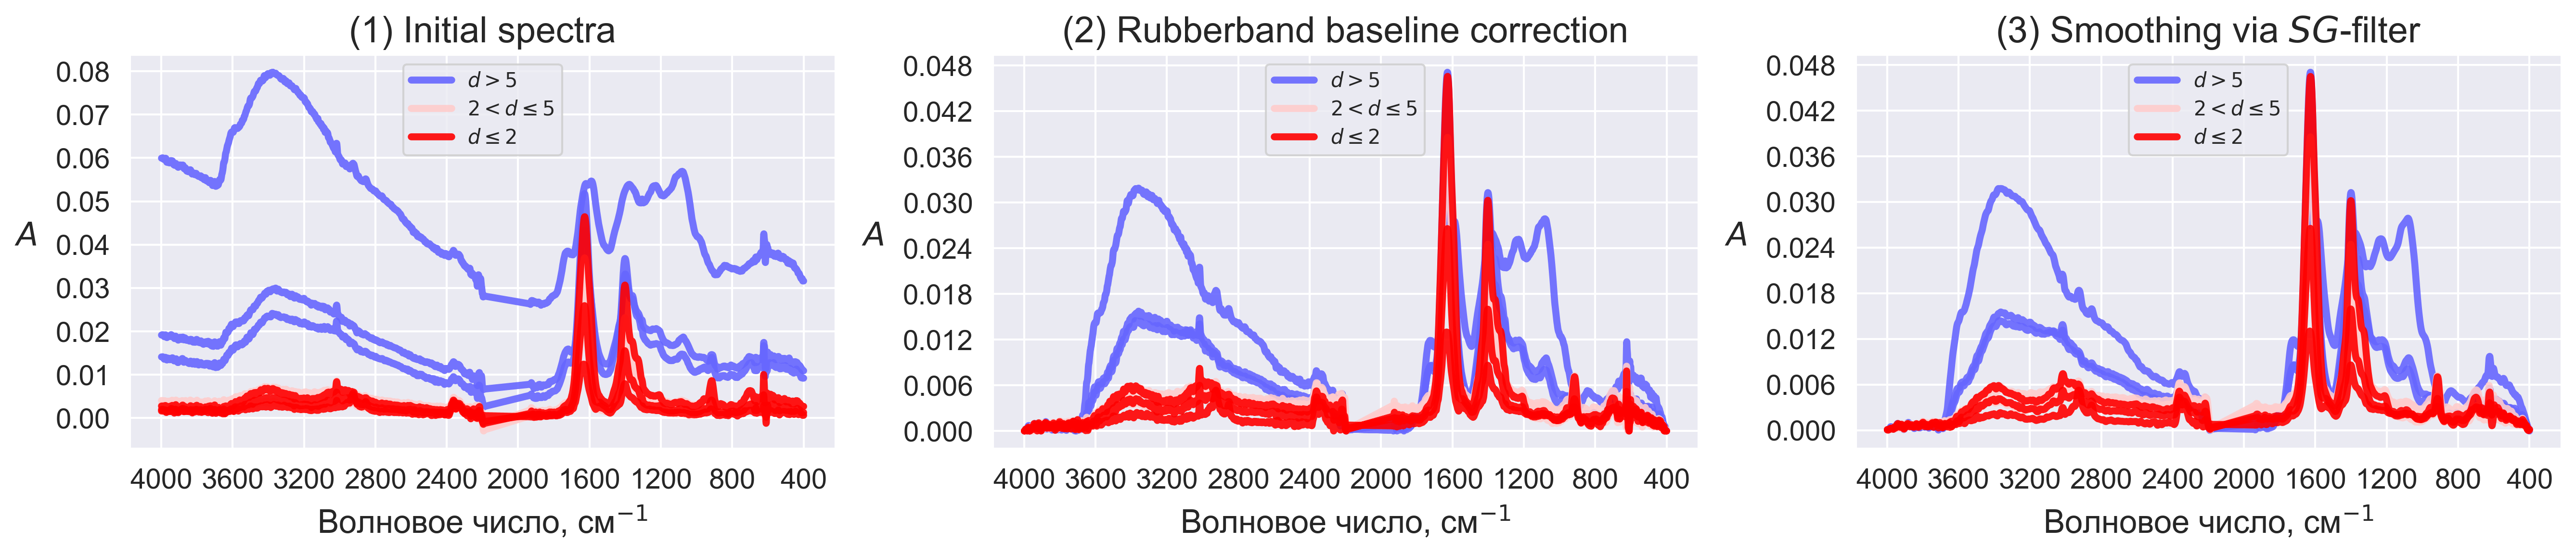

In [31]:
nrows = 1
ncols = 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 4), dpi=300)

for i, division in enumerate([np.int64(9)]):
    # Selecting index for current division
    idx_lst = samples_description.loc[samples_description['Division'] == division].index

    # Selecting parts of data by index
    initial_data_vis = initial_data.loc[idx_lst]
    data_vis = data.loc[idx_lst]
    data_smoothed_vis = data_smoothed.loc[idx_lst]

    # Visualization
    for j, tmp_data in enumerate([initial_data_vis, data_vis, data_smoothed_vis]):

        if i > 0:
            custom_plot_params["TITLE"] = ''
        else:
            custom_plot_params["TITLE"] = '(1) Initial spectra' if j == 0 else '(2) Rubberband baseline correction' if j == 1 else '(3) Smoothing via $SG$-filter'
        
        plot_spectra(
            data_vis=tmp_data,
            ax=axes[j],
            samples_description=samples_description,
            hue_column='Fraction_grouped_hue',  # Fraction_hue, Fraction_grouped_hue
            plot_params=custom_plot_params,
            style_params=custom_style,
            legend_params=custom_legend
        )

plt.tight_layout()

# plt.savefig(f'{path_to_save}/raw_bc_smoothed_spectra.png', dpi=600)

plt.show()

# Saving data

In [19]:
path_to_save_data = './../data/preprocessed_data'

## Smoothed data & smothed data by region

In [20]:
data_smoothed.to_csv(f'{path_to_save_data}/smoothed_data/ftir_smoothed_4000_650.csv', sep=';')
data_smoothed.T.to_csv(f'{path_to_save_data}/smoothed_data/ftir_smoothed_4000_650_transposed.csv', sep=';')

for range, tmp_data in data_smoothed_ranges.items():
    tmp_data.to_csv(f'{path_to_save_data}/smoothed_data/ftir_smoothed_{range[0]}_{range[1]}.csv', sep=';')

## Scaled data by region

In [21]:
for range, tmp_data in data_scaled_ranges.items():
    tmp_data.to_csv(f'{path_to_save_data}/scaled_data/ftir_scaled_{range[0]}_{range[1]}.csv', sep=';')